# Custom Dataset

In [1]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from skimage import io

In [2]:
class AlgaeBloomSedimentationDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,0]) # index is the row while 0 is the col of the image names
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1])) # assign label to col 1 of csv

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

# Main Training Script

In [3]:
import torch.nn as nn # For all nn modules, nn.Linear, nn.Conv2d, BatchNorm, Loss function
import torch.optim as optim # for all optimisation algo, SGC, Adam, etc
import torchvision
import torchvision.transforms as transforms # transformation on dataset
from torch.utils.data import DataLoader # easier dataset management and mini batches creation
import torch.nn.functional as F

from joblib import dump, load
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
dataset = AlgaeBloomSedimentationDataset(csv_file='Training_Images_Label.csv', root_dir='Training_Images\Resized Images', 
                                         transform=transforms.ToTensor())

In [5]:
in_channel = 3
num_classes = 2
learning_rate = 1e-3
batch_size = 8
num_epochs = 10

In [6]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=batch_size, shuffle=True)

In [7]:
model = torchvision.models.mobilenet_v3_small(pretrained=True)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            #x = x.to(device=device)
            #y = y.to(device=device)
            
            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f"Got {num_correct} / {num_samples} with accuracy {float(num_correct) / float(num_samples) * 100:.2f}")

    model.train()

## Training

In [9]:
for epoch in range(num_epochs):
    losses = []

    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        #data = data.to(device=device)
        #targets = targets.to(device=device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        losses.append(loss.item())

        # Backward
        optimizer.zero_grad()
        loss.backward()

        # Gradient descent or adam step
        optimizer.step()

    print(f'Cost at epoch {epoch} is {sum(losses)/len(losses)}')

Cost at epoch 0 is 0.7948716036463156
Cost at epoch 1 is 0.3206153237266699
Cost at epoch 2 is 0.02364844605441249
Cost at epoch 3 is 0.020813035923602
Cost at epoch 4 is 0.04868839403046877
Cost at epoch 5 is 0.01613049737865367
Cost at epoch 6 is 0.03861953329927928
Cost at epoch 7 is 0.004569266693943063
Cost at epoch 8 is 0.041904815564430466
Cost at epoch 9 is 0.0010981833185087454


## Testing

In [10]:
print('Checking accuracy on Training Set')
check_accuracy(train_loader, model)

print('Checking accuracy on Testing Set')
check_accuracy(test_loader, model)

Checking accuracy on Training Set
Got 194 / 198 with accuracy 97.98
Checking accuracy on Testing Set
Got 48 / 50 with accuracy 96.00


## Inference

In [11]:
imageTest = io.imread(r"D:\C - Self-Learning\C - FYP POC2\Trial_Images\trial_algae_1.jpg")

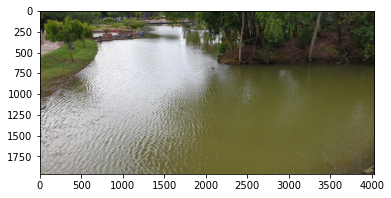

In [12]:
plt.imshow(imageTest)

In [13]:
print(imageTest.shape)
xx = torch.from_numpy(imageTest).permute(2, 0, 1).unsqueeze(0)
print(xx.shape)
print(xx/255)

(1960, 4032, 3)
torch.Size([1, 3, 1960, 4032])
tensor([[[[0.2392, 0.1961, 0.1451,  ..., 0.1137, 0.1529, 0.1608],
          [0.2627, 0.2039, 0.1451,  ..., 0.1412, 0.1765, 0.1882],
          [0.2549, 0.2235, 0.1765,  ..., 0.1529, 0.1451, 0.1451],
          ...,
          [0.7569, 0.7137, 0.6549,  ..., 0.2235, 0.2118, 0.2118],
          [0.6706, 0.6235, 0.5725,  ..., 0.2235, 0.2314, 0.2392],
          [0.6706, 0.6039, 0.5451,  ..., 0.2118, 0.2196, 0.2314]],

         [[0.2706, 0.2275, 0.1647,  ..., 0.1451, 0.1843, 0.1922],
          [0.2941, 0.2353, 0.1647,  ..., 0.1725, 0.2078, 0.2196],
          [0.2745, 0.2431, 0.1961,  ..., 0.1843, 0.1765, 0.1765],
          ...,
          [0.7412, 0.6980, 0.6392,  ..., 0.2235, 0.2118, 0.2118],
          [0.6510, 0.6039, 0.5529,  ..., 0.2235, 0.2314, 0.2392],
          [0.6510, 0.5843, 0.5255,  ..., 0.2118, 0.2196, 0.2314]],

         [[0.1804, 0.1373, 0.0784,  ..., 0.0941, 0.1255, 0.1333],
          [0.2039, 0.1451, 0.0784,  ..., 0.1216, 0.1490, 0.16

In [14]:
scoresT = model(xx/255)
_, predictions = scoresT.max(1)
print(predictions) # 0 - algae, 1 - sedi
print(scoresT) 

tensor([0])
tensor([[ 2.9098e+01,  2.0762e+01,  4.4996e-01,  2.1481e+00,  1.1681e+00,
          2.4937e+00,  1.5140e+00, -1.9600e-01,  7.5584e-01, -1.6094e+00,
         -1.5848e+00,  7.7059e-03, -1.6695e+00,  1.7208e-01,  1.0966e+00,
         -7.8245e-01, -1.3962e+00, -2.8482e+00, -3.3232e+00, -2.0434e+00,
         -1.4773e+00, -2.2599e-01, -1.2792e-02,  8.7764e-01, -2.7517e+00,
          1.0866e+00,  5.0927e+00,  3.7408e+00,  1.9981e+00,  7.6481e+00,
          4.3635e+00,  2.5763e+00,  3.6671e+00,  3.8264e+00,  2.8684e+00,
          4.2621e+00,  5.3443e+00,  2.8788e+00,  1.9506e+00,  2.6366e+00,
          1.8134e+00,  9.4212e-01,  1.6136e+00,  2.4381e+00,  1.8365e+00,
          6.0298e-01,  2.2917e+00,  3.2303e+00,  3.0523e+00,  1.4283e+00,
          1.6888e+00,  3.8804e+00,  9.3682e-01,  1.7483e+00,  6.1501e-03,
          2.3732e+00,  5.8252e-01,  1.3595e+00,  2.8666e+00,  5.5480e-01,
          9.3460e-01,  7.7249e-02,  1.9814e+00,  3.0362e+00,  2.6063e+00,
         -8.0924e-01,  5.0

## Download Model

In [15]:
#dump(model, 'model_v2.2.joblib')

In [16]:
#model_in = load('model_v1.1.joblib')

In [17]:
#scoresT2 = model_in(xx/255)
#_, pred = scoresT2.max(1)
#print(pred)

In [18]:
#print(scoresT2) # algae = 0, sedimentation = 1

In [19]:
torch.save(model.state_dict(), 'model_v2.2.pth')